This notebook includes:



1)the WLS analysis of particulate and dissolved Pa, 


2)the F-statistic 

3)and the map.

In [167]:
import numpy as np
import numpy
import math
import os
import glob,csv
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
% matplotlib inline
nc_filename=sorted(glob.glob('*.csv'))
print("found *.csv file: \n{}".format(nc_filename))

found *.csv file: 
['60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '60changed4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '60changed6.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', 'test.csv']


#Fitting the part. Pa

In [168]:
WLS_err1=np.empty([5,1])
WLS_coef1=np.empty([5,1])
WLS_errc=np.empty([5,1])
WLS_coefc=np.empty([5,1])
sinking_rate=np.empty([5,1])

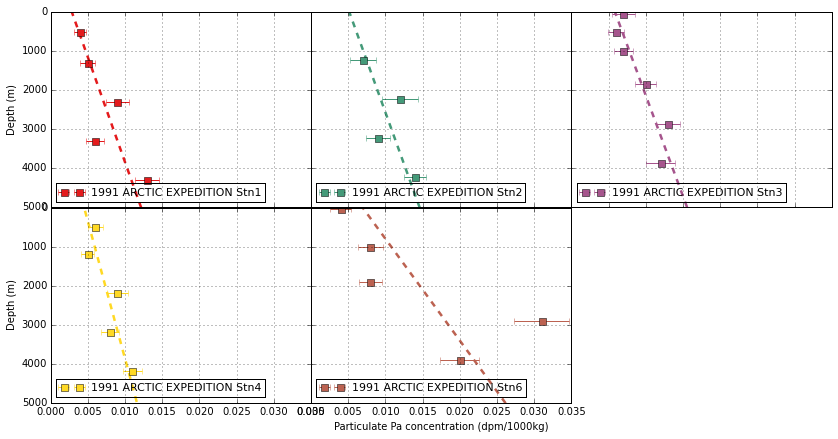

In [169]:
#ax = plt.figure(1,figsize=(10,7))
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    name= data['name'][0];
    x=data['231Pa part.'];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_part_err']
    y2 = sm.add_constant(y,prepend=False)
    mod_wls = sm.WLS(x, y2, weights=1./err)
    res_wls = mod_wls.fit()
    
    WLS_err1[j,:] = res_wls.bse[0]
    WLS_coef1[j,:] = res_wls.params[0]
    sinking_rate[j,:]=0.00246/res_wls.params[0]
    

    #ax = plt.subplot()
    ax = plt.figure(1,figsize=(14,7))
    ax = plt.subplot(2,3,j+1)
    ax.plot([0, 5000],[0, 5000]/res_wls.params[0]-res_wls.params[1]/res_wls.params[0], '--.',c=cm.Set1(j*50),linewidth=2.5)
    ax.errorbar(x, y,xerr=err, fmt='s',markersize=7,c=cm.Set1(j*50),label=name)
    ax.legend(loc=3,fontsize=11)
    
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.035])
    if j+1==1 or j+1==4:
        plt.ylabel('Depth (m)')
    if j+1==5:
        plt.xlabel('Particulate Pa concentration (dpm/1000kg)')
    if j+1==1 or j+1==2 or j+1==3:
        plt.setp(ax.get_xticklabels(), visible=False)
    if not (j+1==1 or j+1==4):
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)

    plt.grid()
    plt.gca().invert_yaxis()
    #plt.tight_layout()
plt.show()

In [170]:
WLS_err2=np.empty([5,1])
Kvalue=np.empty([5,1])
print res_wls2.params[0]

-24.3436641947


#Fitting the diss. Pa

####(1) Change into fit Q-C{1}K{-1}-K{-1}Qz/S

('1991 ARCTIC EXPEDITION Stn1', 'k_pa', -0.036150174626888486)
('1991 ARCTIC EXPEDITION Stn2', 'k_pa', -0.030623348705788558)
('1991 ARCTIC EXPEDITION Stn3', 'k_pa', -0.012901420533756675)
('1991 ARCTIC EXPEDITION Stn4', 'k_pa', -0.032417915171137568)
('1991 ARCTIC EXPEDITION Stn6', 'k_pa', -0.041078450310560247)


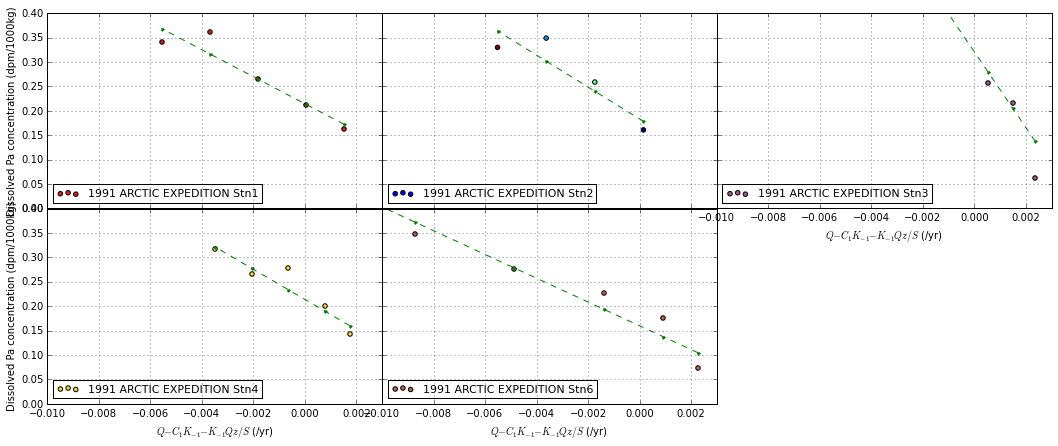

In [171]:
#ax = plt.figure(1,figsize=(10,7))
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    x= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_diss_err']
    y2=np.empty(len(x))
    
    for k in range (len(x)):
        y2[k]=(0.00246-WLS_coef1[j,:])-(0.00246/sinking_rate[j])*y[k]
    y3 = sm.add_constant(y2,prepend=False)
    mod_wls2 = sm.WLS(x,y3, weights=1./err)
    res_wls2 = mod_wls2.fit()
    
    ax = plt.figure(1,figsize=(18,7))
    ax = plt.subplot(2,3,j+1)
    ax.plot(y2, res_wls2.fittedvalues, 'g--.')
    ax.scatter(y2,x,c=cm.Set1(j*50),label=name)
    ax.legend(loc=3,fontsize=11)
    ax.set_ylim([0, 0.4])
    ax.set_xlim([-0.01, 0.003])
    if j+1==1 or j+1==4:
        plt.ylabel('Dissolved Pa concentration (dpm/1000kg)')
    if j+1==3 or j+1==4 or j+1==5:
        plt.xlabel('$Q-C_{1}K_{-1}-K_{-1}Qz/S$ (/yr)')
    if j+1==1 or j+1==2:
        plt.setp(ax.get_xticklabels(), visible=False)
    if not (j+1==1 or j+1==4):
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)
    plt.grid() 
 
    print(name,'k_pa',1/res_wls2.params[0])
plt.show()

In [172]:
#print res_wls2.summary()

####(2)The  Original one (Fit z)

('1991 ARCTIC EXPEDITION Stn1', 'fvalue', 31.155046689122347)
('p_value', 0.011353774665871761)
('Kvalue', array([ 0.07456859]))
('C_analytical', array([-0.06011634]))
('C_real', 0.14673504907345775)
('C_error', array([-0.12623658]))
                  
('1991 ARCTIC EXPEDITION Stn2', 'fvalue', 12.12542477242453)
('p_value', 0.073495095774096686)
('Kvalue', array([ 0.06219916]))
('C_analytical', array([-0.07207156]))
('C_real', 0.10323167301829245)
('C_error', array([-0.16709474]))
                  
('1991 ARCTIC EXPEDITION Stn3', 'fvalue', 26.516096062785859)
('p_value', 0.0067473561316382154)
('Kvalue', array([ 0.02554051]))
('C_analytical', array([-0.17551685]))
('C_real', 0.13029746839102993)
('C_error', array([-0.34981987]))
                  
('1991 ARCTIC EXPEDITION Stn4', 'fvalue', 20.309529715003919)
('p_value', 0.020409724470785186)
('Kvalue', array([ 0.08753997]))
('C_analytical', array([-0.0512085]))
('C_real', 0.13810544399220165)
('C_error', array([-0.10136616]))
        

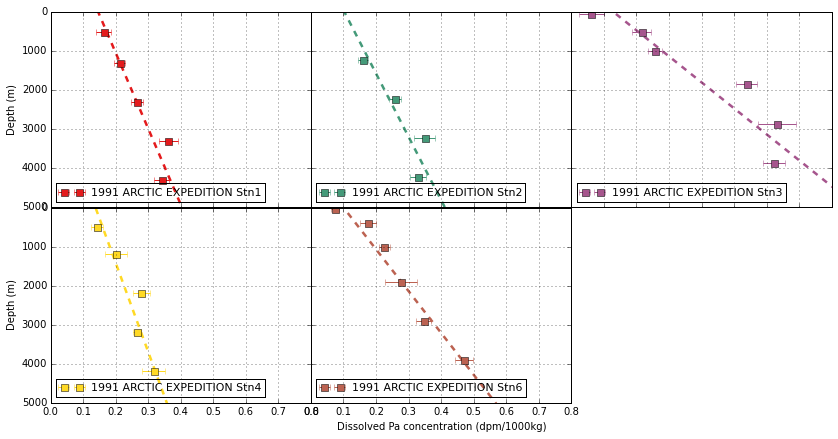

In [173]:
#ax = plt.figure(1,figsize=(10,7))
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    x= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_diss_err']
    y2 = sm.add_constant(y,prepend=False)
    mod_wls2 = sm.WLS(x, y2, weights=1./err)
    res_wls2 = mod_wls2.fit()
    
    WLS_err2[j,:] = res_wls2.bse[0]
    Kvalue[j,:]=1*res_wls.params[0]/res_wls2.params[0]
    WLS_coef2[j,:] = res_wls2.params[0]
    err2=((WLS_err1/WLS_coef1)+(WLS_err2/WLS_coef2))* WLS_coef1/WLS_coef2
    #ax = plt.subplot()
    ax = plt.figure(1,figsize=(14,7))
    ax = plt.subplot(2,3,j+1)
    ax.plot([0, 5000],[0, 5000]/res_wls2.params[0]-res_wls2.params[1]/res_wls2.params[0], '--.',c=cm.Set1(j*50),linewidth=2.5)
    ax.errorbar(x, y,xerr=err, fmt='s',markersize=7,c=cm.Set1(j*50),label=name)
    ax.legend(loc=3,fontsize=11)
    #plt.xlabel('Sea ice concentration');plt.ylabel('Th_concerntration')
    #print ('Fig',j+1,'Pa K value:',Kvalue[j,:])
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.8])
    if j+1==1 or j+1==4:
        plt.ylabel('Depth (m)')
    if j+1==5:
        plt.xlabel('Dissolved Pa concentration (dpm/1000kg)')
    if j+1==1 or j+1==2 or j+1==3:
        plt.setp(ax.get_xticklabels(), visible=False)
    if not (j+1==1 or j+1==4):
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)
    plt.grid() 
    plt.gca().invert_yaxis()
    
    print (name,'fvalue',res_wls2.fvalue)
    print('p_value',res_wls2.pvalues[0])
    print('Kvalue',Kvalue[j,:])
    print('C_analytical',0.00246/Kvalue[j,:]-1.0*res_wls.params[1]/Kvalue[j,:]) ####new
    print('C_real',res_wls2.params[1])
    print('C_error',0.00246/Kvalue[j,:]-(err2[j,:]/Kvalue[j,:]+res_wls.bse[1]/res_wls.params[1])*1.0*res_wls.params[1]/Kvalue[j,:])
    print('                  ')
plt.show()

# WLS: sinking rate and the ice concentration

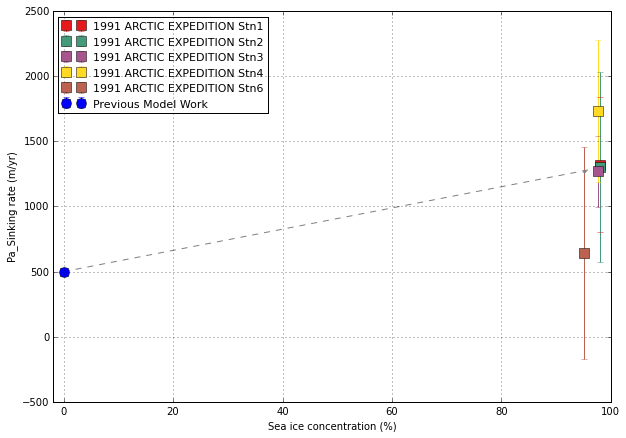

In [174]:
marker=['s','s','s','s','s','s']
#i=np.empty([5,1])
#for j in range(5):
#    data=pd.read_csv(nc_filename[j])
#    i[j,:]= data['ice'][0];
i= np.array([98,98,97.6,97.6,95.2])
    
err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
#((WLS_err1/WLS_coef1)**2)**(0.5)
sinking_rate=numpy.append(sinking_rate,500)
i=numpy.append(i,0)
err1=numpy.append(err1,0.01)
i2 = sm.add_constant(i,prepend=False)
mod_wls3 = sm.WLS(sinking_rate,i2,weights=1./err1) #Is it the real error?
res_wls3 = mod_wls3.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls3.fittedvalues, '--.',color='grey')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)

ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0, fontsize=11)#,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Sinking rate (m/yr)')

#ax.set_ylim([0, 5000])
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [175]:
print res_wls3.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            WLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     29.79
Date:                Fri, 29 May 2015   Prob (F-statistic):            0.00548
Time:                        12:37:14   Log-Likelihood:                -23.363
No. Observations:                   6   AIC:                             50.73
Df Residuals:                       4   BIC:                             50.31
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             8.1456      1.492      5.458      0.005         4.002    12.289
const        499.9998      1.455    343.636      0.0

In [176]:
#res_wls3.fvalue
#res_wls3.params[1]

# WLS: K value and the ice concentration

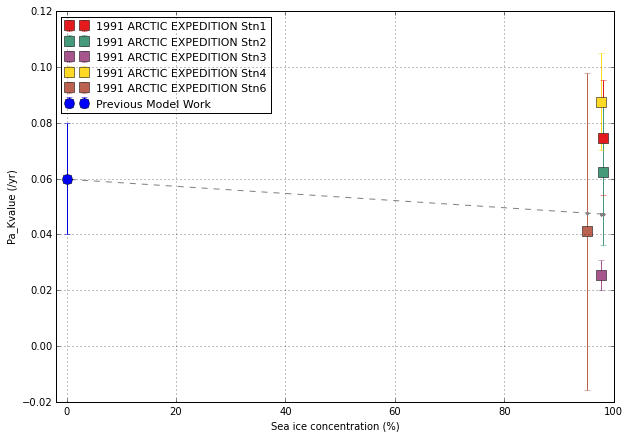

In [177]:
#err2= ((WLS_err1/WLS_coef1)+(WLS_err2/WLS_coef2))* WLS_coef1/WLS_coef2# error of k value K-1=1
#(WLS_coef1**(-4)*(WLS_coef2**(-2))*(WLS_err1)**2+WLS_coef2**(-4)*(WLS_coef1**(-2))*(WLS_err2)**2)**(0.5)
#((WLS_err1/WLS_coef1)**2+(WLS_err2/WLS_coef2)**2)**(0.5) # error of k value K-1=1

Kvalue=numpy.append(Kvalue,0.06)#0.06
err2=numpy.append(err2,0.02)

mod_wls4 = sm.WLS(Kvalue, i2, weights=1./(err2))
res_wls4 = mod_wls4.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls4.fittedvalues,  '--.',color='grey')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)
errorbar(i[-1],Kvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Kvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [178]:
print res_wls4.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                 -0.214
Method:                 Least Squares   F-statistic:                    0.1194
Date:                Fri, 29 May 2015   Prob (F-statistic):              0.747
Time:                        12:37:15   Log-Likelihood:                 1.2952
No. Observations:                   6   AIC:                             1.410
Df Residuals:                       4   BIC:                            0.9931
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0001      0.000     -0.346      0.747        -0.001     0.001
const          0.0598      0.034      1.770      0.1

# F-test(Model)

Test how Prob>F will change with or without the slope.

In [179]:
from statsmodels.formula.api import wls
from scipy.stats import f as scist
data = pd.DataFrame({'Kvalue':Kvalue, 'i2': i})
mod_wls5 = wls('Kvalue~i2', data,weights=1./(err2))
res_wls5 = mod_wls5.fit()
print res_wls5.summary()

                            WLS Regression Results                            
Dep. Variable:                 Kvalue   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                 -0.214
Method:                 Least Squares   F-statistic:                    0.1194
Date:                Fri, 29 May 2015   Prob (F-statistic):              0.747
Time:                        12:37:15   Log-Likelihood:                 1.2952
No. Observations:                   6   AIC:                             1.410
Df Residuals:                       4   BIC:                            0.9931
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0598      0.034      1.770      0.151        -0.034     0.154
i2            -0.0001      0.000     -0.346      0.7

In [180]:
rss=(Kvalue-0.0598)**2*(1./(err2**2))
rss_sum=sum(rss)

print err2
print rss
print rss_sum
print res_wls5.mse_resid

[ 0.0206047   0.02596525  0.00529631  0.01738407  0.05684211  0.02      ]
[  5.13742541e-01   8.53755608e-03   4.18422549e+01   2.54629587e+00
   1.08478373e-01   1.00000000e-04]
45.0194092304
0.0570316469736


In [181]:
p1 = 1
p2 = 2
n = 5
F = (rss_sum - res_wls5.mse_resid)/(res_wls5.mse_resid) *(n-p2)/(p2-p1)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print p
#print F

1.91438013744e-05


#F_test(variables)

In [182]:
print(res_wls4.f_test([1,1]))
#denominator degrees of freedom
#numerator degrees of freedom

<F test: F=array([[ 3.18612542]]), p=[[ 0.1488196]], df_denom=4, df_num=1>


In [183]:
#import csv
#with open('test.csv', 'w') as fp:
#    a = csv.writer(fp, delimiter=',')
#    data = [[0.07456859, 98,0.0206047,0.058],
#            [0.06219916, 98,0.02596525, 0.058],
#            [0.02554051, 97.6,0.00529631, 0.058],
#            [0.08753997, 97.6,0.01738407, 0.058],
#            [0.04107845, 95.2,0.05684211, 0.058],
#            [0.06, 0,0.02 , 0.058]]
#    data = [[0.07456859, 80,0.0206047,0.058],
#            [0.06219916, 70,0.02596525, 0.058],
#            [0.02554051, 70,0.00529631, 0.058],
#            [0.08753997, 80,0.01738407, 0.058],
#            [0.04107845, 80,0.05684211, 0.058],
#            [0.06, 0,0.02 , 0.058]]
#    a.writerows(data)
#data=pd.read_csv('test.csv',header=None,names=['k','ice','err','k2'])
#print data

In [184]:
#from scipy import stats
#from statsmodels.stats.anova import anova_lm 
#from statsmodels.formula.api import wls

#anova_results=anova_lm(wls('k~C(ice)',data).fit())
#print anova_results

In [185]:
#help(anova_lm)
#anova_results=anova_lm(wls('k~k2',data).fit())
#print ('Without slope')
#print anova_results
#print ("    ")
#print ('With slope (originally)')
#print (' F:0.1194, PR(>F):0.747')

# Map

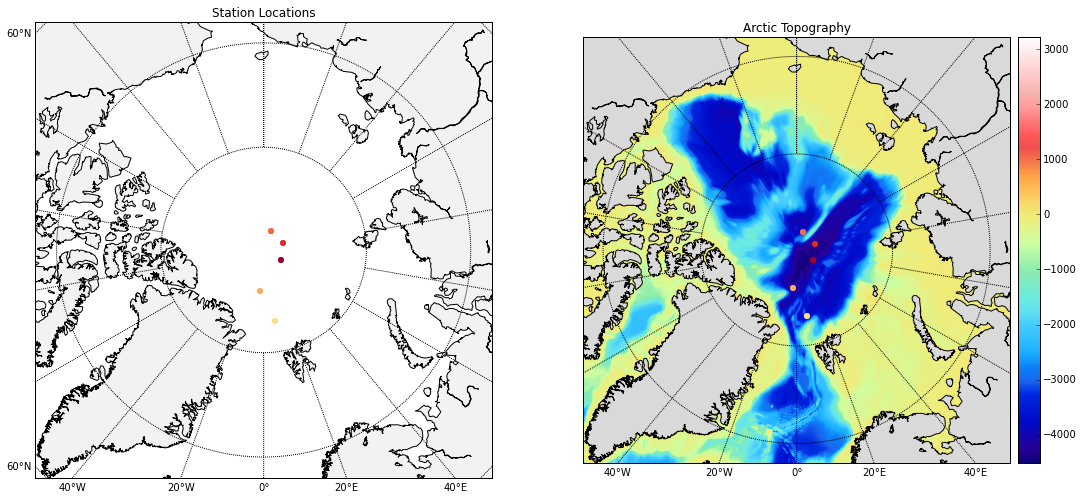

In [186]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(121)

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))
    
plt.title("Station Locations")
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

ax = fig.add_subplot(122)
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,81.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))

nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)    
from mpl_toolkits.basemap import cm    
im = m.imshow(topodat,cm.GMT_haxby)
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.title("Arctic Topography")
plt.show()